# Create a Naive Bayes Model

In this notbook we pull everything together to make winner predictions at given intervals throughout the season.

## Setup

In [242]:
# Need to force reloading of modules before execution
%load_ext autoreload
%autoreload 2

import pickle
import matplotlib.pyplot as plt

%aimport -pickle
%aimport -plt

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seasons = pickle.load( open( "episode_scores.p", "rb" ) )

In [3]:
# %load https://gist.github.com/ajp619/ddaa0f35627b066ef528/raw/cbbd6c6c1cad286ba5a358b93fd94eddede7c4ba/qtutil.py
# silly utility to launch a qtconsole if one doesn't exist

consoleFlag = True
# consoleFlag = False  # Turn on/off by commenting/uncommenting this line

import psutil

def returnPyIDs():
    pyids = set()
    for pid in psutil.pids():
        try:
            if "python" in psutil.Process(pid).name():
                pyids.add(pid)
        except:
            pass
    return pyids

def launchConsole():
    before_pyids = returnPyIDs()
    %qtconsole
    after_pyids = returnPyIDs()
    newid = after_pyids.difference(before_pyids)
    assert len(newid) == 1
    return list(newid)[0]

try:
    print qtid
except NameError:
    if consoleFlag:
        qtid = launchConsole()
        print qtid
    
if consoleFlag and (qtid not in returnPyIDs()):
    qtid = launchConsole()
    print qtid

5896


## Calculate scores

In [217]:
%%writefile naive_bayes.py

import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB

def concat_scores(seasons):
    frames = []
    for k in seasons.keys():
        scores = seasons[k]['features']['scores']
        time_line = np.sort(scores.keys())
        for t in time_line:
            df = scores[t]
            df['season'] = k
            df['time'] = t
            frames.append(df)
    df = pd.concat(frames).reset_index(drop=True)
    df['contestant_id'] = [':'.join(i) for i in zip(df['name'], df['season'])]
    return df

def build_training_data(data, current_time):
    available_times = data.time.unique()
    times_to_use = np.sort(available_times[available_times <= current_time])[::-1]
    frames = []
    active_contestants = set(data.contestant_id)
    ignore_cols = ['name', 'season', 'contestant_id', 'place']
    for t in times_to_use:
        df_t = data.loc[data.time == t, :]
        active_contestants = active_contestants.intersection(df_t.contestant_id)
        ac_filter = [i in active_contestants for i in df_t.contestant_id]
        df_min = df_t.loc[ac_filter, :]
        df_min.columns = [i if i in ignore_cols else i + '-' + str(t) 
                          for i in df_min.columns]
        frames.append(df_min)
    df = frames.pop()
    while len(frames) > 0:
        df_m = frames.pop()
        df = pd.merge(df, df_m.drop(['name', 'season', 'place'], 1), on='contestant_id')
    return df
    
def model_nb(data):
    ignore_cols = ['name', 'season', 'contestant_id'] + \
        [i for i in data.columns if 'time' in i]
    Y = data.place
    X = data.drop(ignore_cols + ['place'], axis=1)
    nb = GaussianNB()
    nb.fit(X, Y)
    predictions = nb.predict_proba(X)
    return {'model': nb, 'predictions': predictions}

def predict_winners(models):
    for t in models.keys():
        model_data = models[t]['data']
        # add predictions col
        model_data['predictions'] = models[t]['nb']['predictions'][:, 1]
        
        models[t]['accuracy'] = {}
        seasons = model_data.groupby('season')
        for season in seasons:
            k = season[0]
            df = season[1]

            models[t]['accuracy'][k] = {}
            return_dict = models[t]['accuracy'][k]
            
            actual_winner = df['name'][df['place'] == 1].values[0]
            predicted_winner = df['name'][df['predictions'] == df['predictions'].max()]
            # solve ties alphabetically (for consitency)
            predicted_winner = sorted(predicted_winner)[0]
            
            return_dict['actual_winner'] = actual_winner
            return_dict['predicted_winner'] = predicted_winner
            return_dict['match'] = actual_winner == predicted_winner
            return_dict['num_remaining'] = df.shape[0]

def predict_season_winners(seasons):
    combined_data = concat_scores(seasons)
    season_times = combined_data.time.unique()
    models = {}
    for t in season_times:
        model_data = build_training_data(combined_data, t)
        trained_model = model_nb(model_data)
        models[t] = {'data': model_data,
                     'nb': trained_model}
    predict_winners(models)
    return models

Overwriting naive_bayes.py


## Run Model

In [218]:
from naive_bayes import *

In [219]:
models = predict_season_winners(seasons)

Parse results.

In [222]:
season = []
actual_winner = []
predicted_winner = []
match = []
time = []
num_remaining = []
for t in sorted(models.keys()):
    for s in models[t]['accuracy']:
        d = models[t]['accuracy'][s]
        
        time.append(t)
        season.append(s)
        actual_winner.append(d['actual_winner'])
        predicted_winner.append(d['predicted_winner'])
        match.append(d['match'])
        num_remaining.append(d['num_remaining'])

df = pd.DataFrame({'time': time,
                   'season': season,
                   'actual_winner': actual_winner,
                   'predicted_winner': predicted_winner,
                   'match': match,
                   'num_remaining': num_remaining})

In [238]:
results = df.groupby('time').agg({'match': 'mean',
                                  'num_remaining': 'mean'})
random_guessing = 1 / results.num_remaining

performance_boost = results.match - random_guessing

performance_boost

time
0.125    0.033766
0.250    0.024681
0.375    0.078180
0.500    0.093870
0.625    0.105184
0.750    0.160277
0.875    0.194717
1.000    0.133413
dtype: float64

## Results

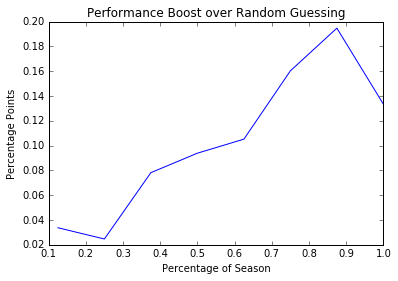

In [245]:
plt.plot(performance_boost.index, performance_boost.values)
plt.title("Performance Boost over Random Guessing")
plt.xlabel("Percentage of Season")
plt.ylabel("Percentage Points")


In [247]:
for t in sorted(models.keys()):
    print "###############"
    print "#    {:5}    #".format(t)
    print "###############"
    for s in models[t]['accuracy']:
        d = models[t]['accuracy'][s]
        print "Season: {:22} :: actual winner    ||  {}".format(s, d['actual_winner'].strip())
        print "        {:22}    predicted winner ||  {}".format('', d['predicted_winner'].strip())
        print "------------------------------------------------------------------"

###############
#    0.125    #
###############
Season: Palau                  :: actual winner    ||  Tom
                                  predicted winner ||  Angie
------------------------------------------------------------------
Season: Tocantins              :: actual winner    ||  J.T.
                                  predicted winner ||  J.T.
------------------------------------------------------------------
Season: Borneo                 :: actual winner    ||  Richard
                                  predicted winner ||  Colleen
------------------------------------------------------------------
Season: Panama                 :: actual winner    ||  Aras
                                  predicted winner ||  Aras
------------------------------------------------------------------
Season: Cambodia               :: actual winner    ||  Jeremy
                                  predicted winner ||  Abi-Maria
------------------------------------------------------------------
Seas